In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf


#can be reused for other scripts
def load_dataset(input_file,folder = "dataset/"):
    return pd.read_csv(folder+input_file,encoding='utf-8')

In [2]:
#load train+test to make all in one dummies 
print('loading train.csv...')
train = load_dataset('train.csv')
#take only small portion
train = train[:1000000]
print('loading test.csv...')
test = load_dataset('test.csv')
test = test[:1000000]
print('extracting target variable')
y_train = train['target']
del train['target']

test_id = test['id']
del test['id']

print('merging datasets')
train = pd.concat([train,test]).reset_index()

#make dummies pit pf source_X
print('Making dummies...')
train = train.join(pd.get_dummies(train['source_system_tab'],prefix='source_system'))\
    .join(pd.get_dummies(train['source_type'],prefix='source_type'))\
    .join(pd.get_dummies(train['source_screen_name'],prefix='source_screen'))
#delete the categoricals made into dummies
del train['source_system_tab']
del train['source_screen_name']
del train['source_type']

#getting the size of training set
training_size = y_train.shape[0]
print("size:",training_size)
test = train[training_size:]
test['id'] = test_id
train = train[:training_size]
train['target'] = y_train
train.head()



loading train.csv...
loading test.csv...
extracting target variable
merging datasets
Making dummies...
size: 1000000


C:\Users\Scarou\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,index,msno,song_id,source_system_discover,source_system_explore,source_system_listen with,source_system_my library,source_system_notification,source_system_null,source_system_radio,...,source_screen_Others profile more,source_screen_Payment,source_screen_People local,source_screen_Radio,source_screen_Search,source_screen_Search Home,source_screen_Search Trends,source_screen_Self profile more,source_screen_Unknown,target
0,0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
#Load members.csv
print('loading members.csv ...')
members = load_dataset('members.csv')

print('getting Events info from training set...')
NumberOfTotalEvents = train.groupby('msno').size()
NumberOfPositive = train[train['target']== 1].groupby('msno').size()

#getting the total events per members
df = NumberOfTotalEvents.to_frame()
df['msno'] = df.index
df.index.name = None
df = pd.DataFrame(df.values)
df = df.rename(columns={0:'nb_events',1:'msno'})

#getting the total Positive events per members
df2 = NumberOfPositive.to_frame()
df2['msno'] = df2.index
df2.index.name = None
df2 = pd.DataFrame(df2.values)
df2 = df2.rename(columns={0:'positive_events',1:'msno'})

#join df and df2
print('joining shit...')
members = members.join(df.set_index('msno'),on='msno').join(df2.set_index('msno'),on='msno')

#getting dummies for gender and NaN genders
print('getting dummies for gender')
members = members.join(pd.get_dummies(members.gender,prefix='gender'))
#delete gender
del members['gender']

#Fill NaNs
print('filling nulls')
members['nb_events'] = members.nb_events.fillna(0)
members['positive_events'] = members['positive_events'].fillna(0)

#getting ratio
print('Calculating positive ratios...')
members['positive_ratio'] = members['positive_events'] / members['nb_events']

#change age to average when odd
mean_age = int(members[(members['bd'] > 10) & (members['bd'] < 80)]['bd'].mean())
mean_age # 28.86 yold
members['bd'] = members['bd'].apply(lambda x: mean_age if (x < 10) or (x > 80) else x)

#Applying minmax to age and nb_events
print('Applying minmaxScaler to age and nb_events')
MMScaler = MinMaxScaler(copy=True, feature_range=(0, 1))
MMScaler.fit(members['bd'].reshape(-1,1))
members['bd'] = MMScaler.transform(members['bd'].reshape(-1,1)).reshape(1,-1)[0]
MMScaler.fit(members['nb_events'].reshape(-1,1))
members['nb_events'] = MMScaler.transform(members['nb_events'].reshape(-1,1)).reshape(1,-1)[0]



#add column: membership_length
members['membership_time'] = members['expiration_date'] -members['registration_init_time']
MMScaler.fit(members['membership_time'].reshape(-1,1))
members['membership_time'] = MMScaler.transform(members['membership_time'].reshape(-1,1)).reshape(1,-1)[0]


#Making the train set, adding to train all the member's stats
del members['city']
del members['registered_via']
del members['expiration_date']
del members['registration_init_time']
del members['positive_events']

members.head(10)

loading members.csv ...
getting Events info from training set...
joining shit...
getting dummies for gender
filling nulls
Calculating positive ratios...
Applying minmaxScaler to age and nb_events


C:\Users\Scarou\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\Scarou\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Scarou\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\Scarou\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\Scarou\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\Scarou\Anaconda3\lib\site-pac

,msno,bd,nb_events,gender_female,gender_male,positive_ratio,membership_time
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,0.264706,0.092478,0,0,0.853333,0.862076
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,0.264706,0.007398,0,0,0.000000,0.792997
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,0.264706,0.009864,0,0,1.000000,0.776301
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,0.264706,0.000000,0,0,NaN,0.758560
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,0.264706,0.000000,0,0,NaN,0.759397
5,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,0.485294,0.000000,1,0,NaN,0.845202
6,Sw9AT8QoR4wWiNUqHZUH6g5ahzGUx4lo1g+Y3xE2f2M=,0.264706,0.000000,0,0,NaN,0.758563
7,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,0.264706,0.083847,0,0,0.029412,0.777161
8,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,0.264706,0.033292,0,0,0.851852,0.863315
9,tscijwx4dbEp0NXGl+iFtHJ8zrj+TkcMrduOQk9t+gE=,0.264706,0.000000,0,0,NaN,0.776465


In [5]:
#join member values on train

joinedTrain =   train.join(members.set_index('msno'),on='msno')
del joinedTrain['target']
joinedTrain.head()

,index,msno,song_id,source_system_discover,source_system_explore,source_system_listen with,source_system_my library,source_system_notification,source_system_null,source_system_radio,...,source_screen_Search Home,source_screen_Search Trends,source_screen_Self profile more,source_screen_Unknown,bd,nb_events,gender_female,gender_male,positive_ratio,membership_time
0,0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,0,1,0,0,0,0,0,...,0,0,0,0,0.264706,0.799014,0,0,0.785494,0.846235
1,1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,0,0,0,1,0,0,0,...,0,0,0,0,0.205882,0.145499,1,0,0.805085,0.862569
2,2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,0,0,0,1,0,0,0,...,0,0,0,0,0.205882,0.145499,1,0,0.805085,0.862569
3,3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,0,0,0,1,0,0,0,...,0,0,0,0,0.205882,0.145499,1,0,0.805085,0.862569
4,4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,0,1,0,0,0,0,0,...,0,0,0,0,0.264706,0.799014,0,0,0.785494,0.846235


In [8]:
songs = load_dataset('formated_songs.csv')
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,愛我的資格
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,Mary Had a Little Lamb


In [31]:
numberOfPlays = train.groupby('song_id').size().to_frame()
numberOfPlays['song_id'] = numberOfPlays.index
numberOfPlays = numberOfPlays.rename(columns={0:'played_number',1:'song_id'})
numberOfPlays.index.name = None


In [35]:
train = train.join(numberOfPlays.set_index('song_id'),on='song_id')

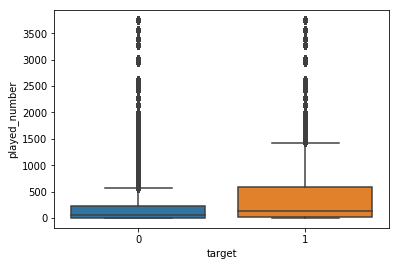

In [37]:
sns.boxplot(x=train['target'],y=train.played_number)

In [38]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,愛我的資格
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,Mary Had a Little Lamb


In [39]:
songs = songs.join(numberOfPlays.set_index('song_id'),on='song_id')

In [44]:
songs = songs.sort_values("played_number",ascending = False)

In [46]:
songs.head(100)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,played_number
1305441,T86YHdD4C9JSc274b1IlMkLuNdz4BQRB50fWWE7hx9g=,215144,458,周杰倫 (Jay Chou),周杰倫,方文山,3.0,告白氣球,3746.0
6692,reXuGcEWDDCnL0K3Th//3DFG4S1ACSpJMzA+CFipo1g=,219324,458,周湯豪 (NICKTHEREAL),周湯豪,周湯豪\崔惟楷,3.0,帥到分手,3552.0
1297626,FynUyq0+drmIARmK1JZ/qcjNZ7DKkqTY6/0O0lTzNUI=,287328,458,Eric 周興哲,Eric Chou,Eric Chou| Yi-Wei Wu,3.0,你，好不好？ (How Have You Been?),3397.0
244856,PgRtmmESVNtWjoZHO5a1r21vIz9sVZmcJJpFCbRa1LI=,227343,465,謝和弦 (R-chord),R-chord,R-chord,3.0,謝謝妳愛我 (Thanks For Your Love),3268.0
92323,U9kojfZSKaiWOW94PKh1Riyv/zUWxmBRmv0XInQWLGw=,290063,458,周杰倫 (Jay Chou),周杰倫,方文山,3.0,不該,3010.0
1938251,wBTWuHbjdjxnG1lQcbqnK4FddV24rUhuyrYLd9c/hmk=,265508,465,田馥甄 (Hebe),JerryC,徐世珍/吳輝福,3.0,小幸運 (A little happiness),2962.0
68238,M9rAajz4dYuRhZ7jLvf9RRayVA3os61X/XXHEuW4giA=,265848,465,林俊傑 (JJ Lin),JJ Lin,Lin Qiu Li,3.0,不為誰而作的歌 (Twilight),2610.0
1660520,fCCmIa0Y5m+MCGbQga31MOLTIqi7ddgXvkjFPmfslGw=,283747,458,aMEI (張惠妹),Lei Qian,NaN,3.0,默,2576.0
141836,IKMFuL0f5Y8c63Hg9BXkeNJjE0z8yf3gMt/tOxF4QNE=,244976,1609,The Chainsmokers,Andrew Taggart| Shaun Frank| Frederic Kennett|...,Andrew Taggart| Shaun Frank| Frederic Kennett|...,52.0,Closer,2565.0
941735,43Qm2YzsP99P5wm37B1JIhezUcQ/1CDjYlQx6rBbz2U=,346272,458,五月天 (Mayday),怪獸,阿信,3.0,後來的我們 (Here| After| Us),2561.0
